### Loading G-Drive

In [2]:
# from google.colab import drive  
# drive.mount('/content/gdrive', force_remount=True)

### Importing the Libraries

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.transform import resize
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Reshape, Conv2DTranspose, MaxPooling2D, Flatten, Dense, BatchNormalization,GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

2023-05-04 22:45:29.522381: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 22:45:29.579116: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-04 22:45:29.904681: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/till/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-05-04 22:45:29.904713: W tens

In [3]:
# %cd /content/gdrive/MyDrive/images/dida_task

## Approach 1

#### Image Processing without Augmentation

In [237]:
def train_test_img_loader(path: list[str], size:int)-> np.array:
  image_files = [f"{i}.png" for i in range(1, len(os.listdir(path))+1)]
  images = []
  for file in image_files:
    image_path = os.path.join(path, file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = resize(image, (size,size))
    images.append(resized_image)
  return np.array(images)

def label_img_loader(path:list[str],size:int)-> np.array:
  image_files = [f"{i}.png" for i in range(1, len(os.listdir(path))+1)]
  images = []
  for file in image_files:
    image_path = os.path.join(path, file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray_label = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    resized_label = resize(gray_label, (size,size))
    #binary_image = np.where(image>0.5,1,0)
    thr_label = (resized_label > 0.5).astype('float32') # Binary Masking for the pixels, any pixel value greater than 0.5 is considered as part of roof else not roof.
    #proportion = np.sum(binary_image)/(image.shape[0] * image.shape[1])
    images.append(thr_label)
  return np.array(images)

### Load Images and preprocess them

In [170]:
train_image_path = './train/images'
train_label_path = './train/labels'
test_image_path = './test/images'

val_image_path = './val/images'
val_label_path = './val/labels'

train_images = train_test_img_loader(train_image_path,224)
train_labels = label_img_loader(train_label_path,224)
test_images = train_test_img_loader(test_image_path,224)

val_images = train_test_img_loader(val_image_path,224)
val_labels = label_img_loader(val_label_path,224)

# Normalizing the images and making label images having enough channels for NN.
processed_train_images = train_images.astype('float32')
processed_train_labels = train_labels.reshape(*train_labels.shape, 1)
processed_test_images = test_images.astype('float32')

processed_val_images = val_images.astype('float32')
processed_val_labels = val_labels.reshape(*val_labels.shape, 1)

#### Viewing the images

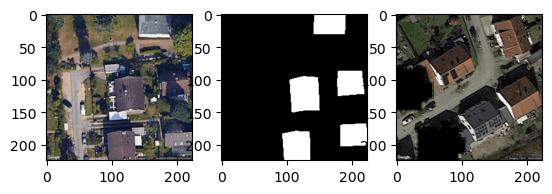

In [160]:
fig, axs = plt.subplots(1, 3)
axs[0].imshow(processed_train_images[0])
axs[1].imshow(processed_train_labels[0].squeeze(), cmap='gray')
axs[2].imshow(processed_test_images[0])
plt.show()

### Modelling

### Unet

In [162]:
# !pip install git+https://github.com/tensorflow/examples.git

In [163]:
from tensorflow_examples.models.pix2pix import pix2pix

In [220]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

##################

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

##################

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

##################


def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # Append another Conv2DTranspose layer with appropriate parameters
  x = tf.keras.layers.Conv2DTranspose(
      filters=64, kernel_size=3, strides=2,
      padding='same')(x)

  x = tf.keras.layers.Conv2D(
      filters=1, kernel_size=1, strides=1,
      padding='valid')(x)
    
  # x = tf.keras.layers.Cropping2D(cropping=96)(x)
    
  x = tf.keras.activations.sigmoid(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

# build the model
unet = unet_model(output_channels=1)

unet.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

unet(processed_train_images).shape

TensorShape([20, 224, 224, 1])

In [232]:
unet.fit(
    processed_train_images, 
    processed_train_labels,
    epochs=20,
    batch_size=3,
    validation_data=(processed_val_images, processed_val_labels)
)


Epoch 1/20
7/7 [==============================] - 1s 185ms/step - loss: 0.0041 - accuracy: 0.9987 - val_loss: 0.5460 - val_accuracy: 0.9148
Epoch 2/20
7/7 [==============================] - 1s 179ms/step - loss: 0.0048 - accuracy: 0.9983 - val_loss: 0.5343 - val_accuracy: 0.9169
Epoch 3/20
7/7 [==============================] - 1s 182ms/step - loss: 0.0064 - accuracy: 0.9976 - val_loss: 0.5512 - val_accuracy: 0.9150
Epoch 4/20
7/7 [==============================] - 1s 177ms/step - loss: 0.0065 - accuracy: 0.9974 - val_loss: 0.5245 - val_accuracy: 0.9177
Epoch 5/20
7/7 [==============================] - 1s 177ms/step - loss: 0.0084 - accuracy: 0.9967 - val_loss: 0.5319 - val_accuracy: 0.9172
Epoch 6/20
7/7 [==============================] - 1s 175ms/step - loss: 0.0078 - accuracy: 0.9969 - val_loss: 0.5455 - val_accuracy: 0.9173
Epoch 7/20
7/7 [==============================] - 1s 178ms/step - loss: 0.0082 - accuracy: 0.9967 - val_loss: 0.5153 - val_accuracy: 0.9181
Epoch 8/20
7/7 [====

1/1 [==============================] - 0s 126ms/step


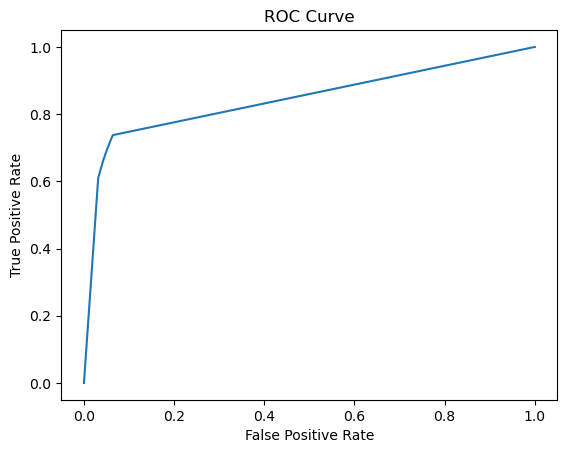

In [233]:
from sklearn.metrics import confusion_matrix

predicted_images = unet.predict(processed_val_images)

# Threshold the predicted images using different threshold values
thresholds = np.arange(0, 1.05, 0.05) # check all thresholds from 0-1 in 0.05 interval
tprs = []
fprs = []

for threshold in thresholds:
    # apply threshold and convert to binary images
    
    binary_images = (predicted_images > threshold).astype('uint8')
    binary_images = np.reshape(binary_images, (-1, 224, 224, 1))
    
    # calculate confusion matrix
    cm = confusion_matrix(processed_val_labels.flatten(), binary_images.flatten())
    tn, fp, fn, tp = cm.ravel()
    
    # calculate TPR and FPR
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    tprs.append(tpr)
    fprs.append(fpr)

# plot the ROC curve
plt.plot(fprs, tprs)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [238]:
from scipy.spatial.distance import euclidean

# calculate distance to top left corner for each point on the ROC curve
distances = [euclidean([0, 1], [fprs[i], tprs[i]]) for i in range(len(fprs))]

# find index of point with smallest distance
best_index = np.argmin(distances)

# get corresponding threshold value
best_threshold = thresholds[best_index]

print(f'Best threshold: {best_threshold:.2f}')


Best threshold: 0.05


1/1 [==============================] - 0s 104ms/step


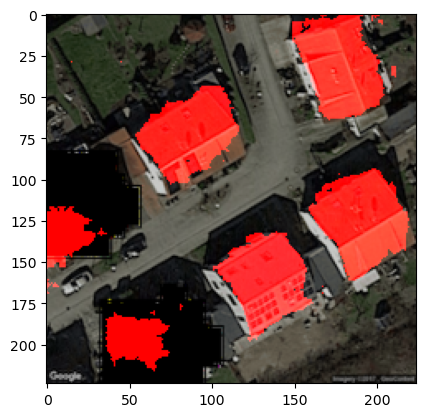

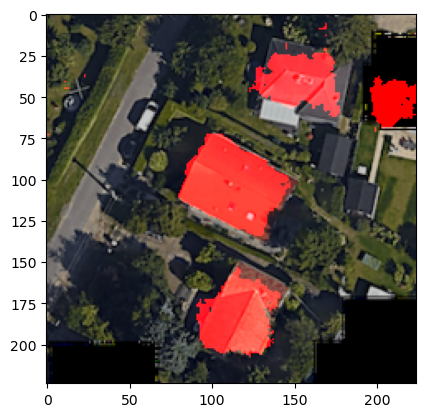

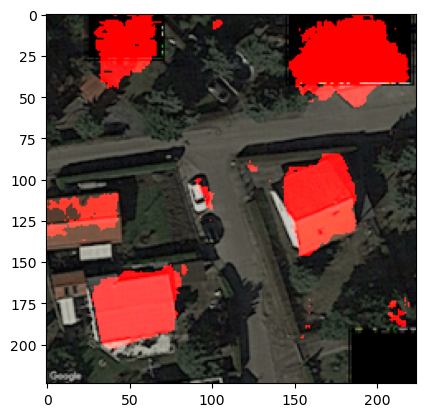

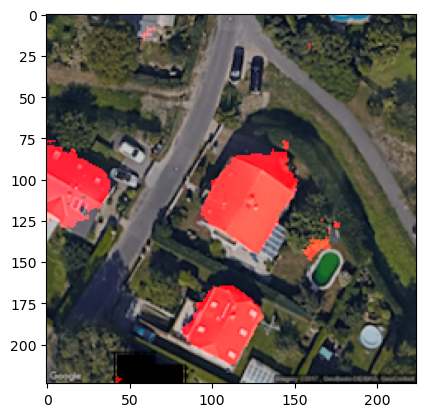

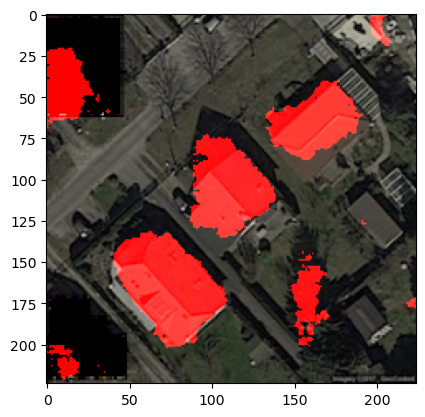

In [235]:
threshold = best_threshold # set threshold value
predicted_images = unet.predict(test_images) # predict on test images

# apply threshold and convert to binary images
binary_images = (predicted_images > threshold).astype('uint8')
binary_images = np.reshape(binary_images, (-1, 224, 224, 1))
# highlight rooftops in binary images
for i in range(binary_images.shape[0]):
    test_image = test_images[i]
    test_image = cv2.resize(test_image, (224, 224), interpolation=cv2.INTER_LINEAR)
    binary_image = binary_images[i].squeeze()
    rooftop_image = np.zeros_like(test_image)
    rooftop_image[:,:,0] = binary_image*255 # set red channel to binary image
    final_image = cv2.addWeighted(test_image, 0.8, rooftop_image, 0.2, 0) # blend images
    plt.imshow(final_image)
    plt.show()